In [1]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
import seaborn as sns  # for coloring 

# set style of graphs
plt.style.use('seaborn')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [3]:
scaler = StandardScaler()

In [4]:
df = pd.read_csv('../../stock/MSFT.csv', parse_dates=True, index_col='Date')
X_train, X_test = train_test_split(df, test_size=0.1, shuffle=False)

In [5]:
df = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

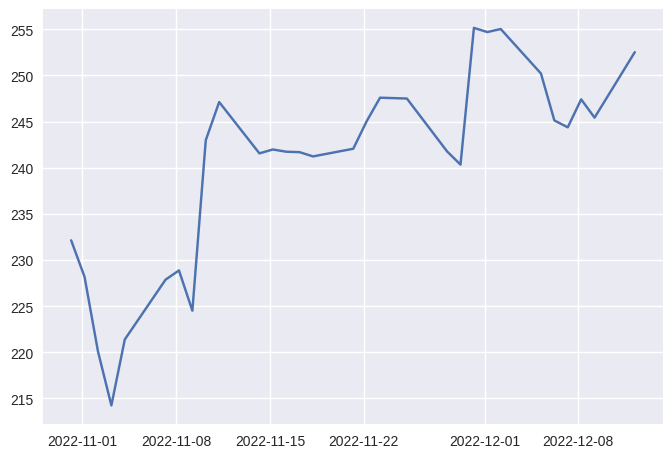

In [6]:
y_test = (X_test['Close']).values
test_data = X_test[-30:]
days = np.array(test_data.index, dtype="datetime64[ms]")
            
fig = plt.figure()
            
axes = fig.add_subplot(111)
axes.plot(days, y_test[-30:], label="actual") 

In [7]:
dict = {
    'mean' : scaler.mean_[3],
    'std' : scaler.scale_[3]
}

In [8]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [9]:
target= "Close"
features = ['High', 'Low', 'Open', 'Volume']

In [10]:
"""
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev
"""

'\ntarget_mean = df_train[target].mean()\ntarget_stdev = df_train[target].std()\n\nfor c in df_train.columns:\n    mean = df_train[c].mean()\n    stdev = df_train[c].std()\n\n    df_train[c] = (df_train[c] - mean) / stdev\n    df_test[c] = (df_test[c] - mean) / stdev\n'

In [11]:
i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.3386, -1.3320, -1.3326, -0.6904],
        [-1.3382, -1.3322, -1.3347, -0.8649],
        [-1.3306, -1.3309, -1.3353, -0.5010],
        [-1.3323, -1.3228, -1.3264, -0.8590]])


In [12]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 4])
tensor([[[-1.1686, -1.1584, -1.1636, -1.0859],
         [-1.1693, -1.1577, -1.1657, -1.3224],
         [-1.1716, -1.1589, -1.1651, -0.9668],
         [-1.1688, -1.1574, -1.1626, -1.2487]],

        [[ 0.5944,  0.5702,  0.5439,  0.6624],
         [ 0.6141,  0.6266,  0.6066, -0.5036],
         [ 0.5891,  0.6136,  0.6117, -0.8167],
         [ 0.5897,  0.6186,  0.5911, -1.4688]],

        [[-0.4842, -0.4685, -0.4685,  0.0911],
         [-0.4588, -0.4462, -0.4433, -0.5035],
         [-0.4602, -0.4416, -0.4496, -1.0937],
         [-0.4463, -0.4299, -0.4413, -1.2224]]])


In [13]:
torch.manual_seed(101)

batch_size = 24
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([24, 30, 4])
Target shape: torch.Size([24])


In [14]:
train_loader

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.2):
        super().__init__()
        self.input_dim = input_dim  # this is the number of features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        x = self.dropout(x)
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [16]:
model = LSTM(input_dim=4, hidden_dim=32, num_layers=2, output_dim=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print("Train loss: {:.6f}".format(avg_loss))

'''
def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
'''

num_epochs = 10
for t in range(num_epochs):
    train_model(train_loader, model, loss_function, optimizer=optimizer)

Train loss: 0.093715
Train loss: 0.001208
Train loss: 0.001147


KeyboardInterrupt: 

In [ ]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


y_pred = predict(test_loader, model) * dict['std'] + dict['mean']

In [ ]:
y_test = (df_test['Close']).values * dict['std'] + dict['mean']

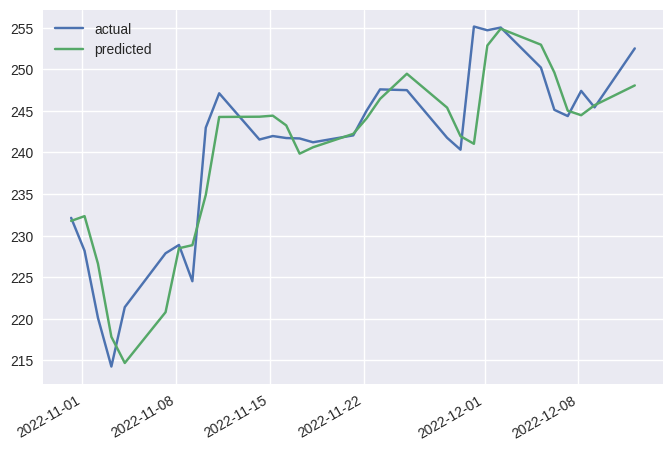

In [ ]:
test_data = df_test[0: len(df_test)]
days = np.array(test_data.index, dtype="datetime64[ms]")
actual_close_prices = test_data['Close']
 
fig = plt.figure()
 
axes = fig.add_subplot(111)
axes.plot(days[-30:], y_test[-30:], label="actual") 
axes.plot(days[-30:], y_pred[-30:], label="predicted")
 
fig.autofmt_xdate()
 
plt.legend()
plt.show()

In [ ]:
testScore = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.67 RMSE


here
here
fitting
predict
1/1 [==============================] - 1s 574ms/step


/tmp/ipykernel_20612/727421501.py:69: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


<AxesSubplot:title={'center':'SAN'}, xlabel='Date'>

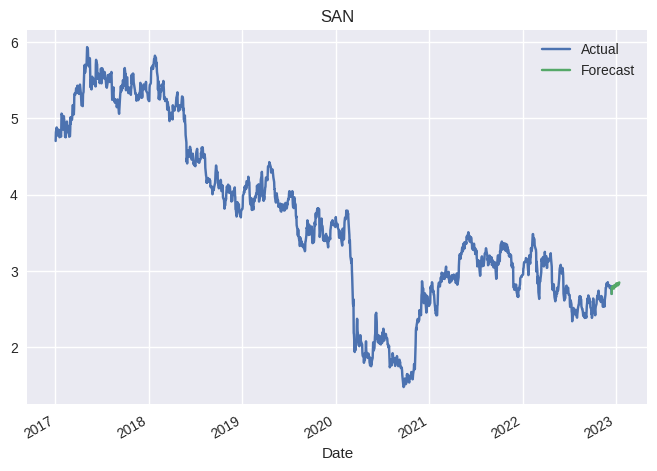

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# download the data
df = pd.read_csv('../../stock/SAN.csv', parse_dates=True, index_col='Date').dropna(how='any')
y = df['Close']
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)

print("here")

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

print("here")

model.compile(loss='mean_squared_error', optimizer='adam')
print("fitting")
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

print("predict")
Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title='SAN')

In [ ]:
results['Forecast'][-30:]

Date
2022-12-16    2.782895
2022-12-17    2.761211
2022-12-18    2.771802
2022-12-19    2.791624
2022-12-20    2.786035
2022-12-21    2.795013
2022-12-22    2.786139
2022-12-23    2.772197
2022-12-24    2.766442
2022-12-25    2.808417
2022-12-26    2.806333
2022-12-27    2.796835
2022-12-28    2.800714
2022-12-29    2.815423
2022-12-30    2.788376
2022-12-31    2.803621
2023-01-01    2.813586
2023-01-02    2.828474
2023-01-03    2.835767
2023-01-04    2.806942
2023-01-05    2.813547
2023-01-06    2.822311
2023-01-07    2.813573
2023-01-08    2.828985
2023-01-09    2.810023
2023-01-10    2.827738
2023-01-11    2.839878
2023-01-12    2.822899
2023-01-13    2.833424
2023-01-14    2.846614
Name: Forecast, dtype: float64